# Week 9 - Beyond Text

This week, we "trascend" text to explore analysis of sound and visual content. Trillions of digital audio, image, and video files have been generated by cell phones and distributed sensors, preserved and shared through social medial, the web, private and government administrations. In this notebook, we read in and visualize audio and image files, process them to extract relevant features and measurement, then begin to explore how to analyze and extract information from them through the same approaches to supervised and unsupervised learning we have performed thoughout the quarter with text.

For this notebook we will use the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import scipy #For frequency analysis
import scipy.fftpack
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import IPython #To show stuff

#Image handling install as Pillow
import PIL
import PIL.ImageOps

#install as scikit-image, this does the image manupulation
import skimage
import skimage.feature
import skimage.segmentation
import skimage.filters
import skimage.color
import skimage.graph
import skimage.future.graph

#these three do audio handling
import pydub #Requires ffmpeg to be installed https://www.ffmpeg.org/download.html; on a mac "brew install ffmpeg"
import speech_recognition #install as speechrecognition
import soundfile #Install as pysoundfile 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning it may generate.
%matplotlib inline

import os
import os.path
import csv
import re

# Audio analysis 

First we will consider media that predates written language...sound and spoken language. Audio (and video) files come in two major categories, lossy or lossless. Lossless files save all information the microphone recorded. Lossy files, by contrast, drop sections humans are unlikely to notice. Recorded frequencies for both types are then typically compressed, which introduces further loss. To work with audio files, we want a format that is preferably lossless or minimally compressed. We will work with `wav` files here. Note that `mp3` is not acceptable. If you do not have `wav` files, we can use python to convert to `wav`.

In [ ]:
samplePath = '../data/audio_samples/SBC060.mp3'
transcriptPath = '../data/audio_samples/SBC060.trn'

IPython.display.Audio(samplePath)

In [ ]:
# We are using a different package to convert than the in the rest of the code
def convertToWAV(sourceFile, outputFile, overwrite = False):
    if os.path.isfile(outputFile) and not overwrite:
        print("{} exists already".format(outputFile))
        return
    #Naive format extraction
    sourceFormat = sourceFile.split('.')[-1]
    sound = pydub.AudioSegment.from_file(sourceFile, format=sourceFormat)
    sound.export(outputFile, format="wav")
    print("{} created".format(outputFile))
wavPath = 'sample.wav'
convertToWAV(samplePath, wavPath)

Now that we have created our `wav` file, notice that it is much larger than the source `mp3`. We can load it with `soundfile` and work with it as a numpy data array.

In [ ]:
soundArr, soundSampleRate = soundfile.read(wavPath)
soundArr.shape

This is the raw data as a column array, which contains two channels (Left and Right) of the recording device. Some files, of course, will have more columns (from more microphones). The array comprises a series of numbers that measure the location of the speaker membrane (0=resting location). By quickly and rhythmically changing the location a note can be achieved. The larger the variation from the center, the louder the sound; the faster the oscillations, the higher the pitch. (The center of the oscillations does not have to be 0).

In [ ]:
soundSampleRate

The other piece of information we get is the sample rate. This tells us how many measurements made per second, which allows us to know how long the entire recording is:

In [ ]:
numS = soundArr.shape[0] // soundSampleRate
print("The sample is {} seconds long".format(numS))
print("Or {:.2f} minutes".format(numS / 60))

The final critical parameter of sound digitization is quantisation, which consists in assigning a value to each sample according to its amplitude. These values are attributed according to a bit scale. A quantisation of 8 bit will assign amplitude values along a scale of $2^8 = 256$ states around 0. Most recording systems use a $2^{16} = 65536$ bit system. Quantisation is a rounding process, where high bit quantisation produces values close to reality with values rounded to a high number of significant digits, and low bit quantisation produces values further from reality with values rounded a low number of significants digits. Low quantisation can lead to impaired quality signal. <img src="../data/bitrate.png"> This figure illustrates how digital sounds is a discrete process along the amplitude scale: a 3 bit, $2^3=8$, quantization (gray bars) gives a rough approximation of the sin wave (red line).

Let's look at the first second of the recording:

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(soundArr[:soundSampleRate])
plt.show()

We get 2 (Left and Right) nearly "flat" (or equally wavy) lines. This means that there is very little noise at this part of the recording. What variation exists is due to compression or interference and represents the slight hiss you sometimes hear in low quality recordings.

Let's expand our scope and look at the first 10 seconds:

In [ ]:
soundArr.shape

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(soundArr[:soundSampleRate * 10])
plt.show()

Now we can see definite spikes, where each represents a word or discrete sound.

To see what the different parts correspond to, we can use a transcript. Because we got this file from the [Santa Barbara Corpus of Spoken American English
](http://www.linguistics.ucsb.edu/research/santa-barbara-corpus#Contents), we just need to load the metadata, which includes a transcription.

In [ ]:
def loadTranscript(targetFile):
    #Regex because the transcripts aren't consistent enough to use csv
    regex = re.compile(r"(\d+\.\d+)\s(\d+\.\d+)\s(.+:)?\s+(.*)")
    dfDict = {
        'time_start' : [],
        'time_end' : [],
        'speaker' : [],
        'text' : [],
    }
    with open(targetFile, encoding='latin-1') as f:
        for line in f:
            r = re.match(regex, line)
            dfDict['time_start'].append(float(r.group(1)))
            dfDict['time_end'].append(float(r.group(2)))
            if r.group(3) is None:
                dfDict['speaker'].append(dfDict['speaker'][-1])
            else:
                dfDict['speaker'].append(r.group(3))
            dfDict['text'].append(r.group(4))
    return pandas.DataFrame(dfDict)

transcriptDF = loadTranscript(transcriptPath)
transcriptDF[:10]

Now let's look at a few sub-sections. First, to make things easier, we will convert the seconds markers to sample indices:

In [ ]:
#Need to be ints for indexing, luckily being off by a couple indices doesn't matter
transcriptDF['index_start'] = (transcriptDF['time_start'] * soundSampleRate).astype('int')
transcriptDF['index_end'] = (transcriptDF['time_end'] * soundSampleRate).astype('int')

Lets see what `'Rae and I and Sue and Buddy,'` looks like, which is the seventh row:

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
subSample1 = soundArr[transcriptDF['index_start'][6]: transcriptDF['index_end'][6]]
ax.plot(subSample1)
plt.show()

And now let's hear what that sounds like:

In [ ]:
soundfile.write('../data/audio_samples/sample1.wav', subSample1, soundSampleRate)
IPython.display.Audio('../data/audio_samples/sample1.wav')

In order to see sounds in the frequency space, we can take the Fourier transform. This is a reversible mathematical transform named after the French mathematician Joseph Fourier (1768-1830) <img src="data/Fourier.jpg">. The transform decomposes a time series into a sum of finite series of sine or cosine functions.

In [ ]:
sample1FFT = scipy.fftpack.ifft(subSample1)
N = len(sample1FFT)
freq = scipy.fftpack.fftfreq(N, d = 1 / soundSampleRate)
fig, ax = plt.subplots(figsize = (15, 7))
ax.set_xlabel('Frequency ($Hz$)')
ax.set_ylabel('Intensity')
ax.plot(freq[:N//2], abs(sample1FFT)[:N//2]) #Only want positive frequencies
plt.show()

This shows that there are two frequencies to the 'Rae and I and Sue and Buddy' snippet: a higher pitched 'Rae and I...Sue...Buddy' (~14000 *Hz*) and the final two 'and's (one at ~6000 *Hz* and the second at ~8000 *Hz*).

What does a sniff look like?

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
subSample2 = soundArr[transcriptDF['index_start'][9]: transcriptDF['index_end'][9]]
ax.plot(subSample2)
plt.show()

Very different from speech. And now let's see what that sounds like:

In [ ]:
soundfile.write('../data/audio_samples/sample2.wav', subSample2, soundSampleRate)
IPython.display.Audio('../data/audio_samples/sample2.wav')

and in frequency space:

In [ ]:
sample2FFT = scipy.fftpack.ifft(subSample2)
N = len(sample2FFT)
freq = scipy.fftpack.fftfreq(N, d = 1 / soundSampleRate)
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(freq[:N//2], abs(sample2FFT)[:N//2]) #Only want positive frequencies
ax.set_xlabel('Frequency ($Hz$)')
ax.set_ylabel('Intensity')
plt.show()

Notice how there is not a dominant frequency for the sniff as there was for the noun phrase earlier. This means that the sniff activated noise all across the frequency spectrum.

We can also investigate dominant frequencies for the entire record:

In [ ]:
#This takes a while
fig, ax = plt.subplots(figsize = (15, 7))
fullFFT = scipy.fftpack.ifft(soundArr)
N = len(fullFFT)
freq = scipy.fftpack.fftfreq(N, d = 1 / soundSampleRate)
ax.plot(freq[:N//2], abs(fullFFT)[:N//2]) #Only want positive frequencies
ax.set_xlabel('Frequency ($Hz$)')
ax.set_ylabel('Intensity')
plt.show()

In [ ]:
freq[len(freq) // 2 -10: len(freq) // 2 + 5]

Here we capture each person's frequencies across their entire collection of statements:

In [ ]:
def maxfreq(sample, topN = 10):
    sampleFFT = scipy.fftpack.ifft(sample)
    N = len(sample)
    freqs = scipy.fftpack.fftfreq(N, d = 1 / soundSampleRate)
    tops =  np.argpartition(abs(sampleFFT[:, 0]), -topN)[-topN:]

    return np.mean(tops) 

freqs = []
for i, row in transcriptDF.iterrows():
    freqs.append(maxfreq(soundArr[row['index_start']: row['index_end']]))

transcriptDF['frequency FFT'] = freqs

Alan's speech exhibits the following frequencies:

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
transcriptDF[transcriptDF['speaker'] == 'ALAN:'].plot( 'time_start', 'frequency FFT', ax = ax)
ax.set_ylabel("Frequency FFT space")
plt.show()

...while Jon's voice is **much** lower:

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
transcriptDF[transcriptDF['speaker'] == 'JON:'].plot( 'time_start', 'frequency FFT', ax = ax)
ax.set_ylabel("Frequency FFT space")
plt.show()

Or we can look at them togther

In [ ]:
fg = seaborn.FacetGrid(data=transcriptDF, hue='speaker', aspect = 3)
fg.map(plt.scatter, 'time_start', 'frequency FFT').add_legend()

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that read in 10 audio files (e.g., produced on your smartphone recorder?) from at least two different speakers, which include sentences of different types (e.g., question, statement, exclamation). At least two of these should include recordings of the two speakers talking to each other (e.g., a simple question/answer). Contrast the frequency distributions of the words spoken within speaker. What speaker's voice has a higher and which has lower frequency? What words are spoken at the highest and lowest frequencies? What parts-of-speech tend to be high or low? How do different types of sentences vary in their frequency differently? When people are speaking to each other, how do their frequencies change? Whose changes more?

### <span style="color:blue">Data</span>

<span style="color:blue"> The audio files I use here are from two sources, with 5 speakers in total. There are 13 audio files in total. 10 of them are from a program called 60 Second Science, including 3 main speakers and several interviewees. And the other 3 are recorded by my cell phone. One of them is a lecture recording of a class instructor of Uchicago. Another one of them is a recording of myself, preparation of a presentation. And the last one is his conversation with me during office hour, which was recorded under his requirement.</span>

<span style="color:blue"> For Exercise 1, I would use 7 of the 60 Second Science audio, and the 3 audio recorded by my cellphone. The 7 audio of 60 Second Science are from two hosts, Christopher Intagliata and Steve Mirsky. Although I have spent hours trying to install ffmpeg properly, I still can't get it work in my laptop. So I manually converted all the files into .wav format, and directly use them here.</span>

<span style='color:blue'> With these audio, I would compare the frequenciy distributions between audio hosts and ordinary people, compare the frequency distribution between native speaker (the professor) and me as a foreigner, and compare the frequency distribution between our solo speech and conversation.</span>

In [2]:
# Read-in the data
dir_audio = '/Users/hsswyx/Desktop/content_analysis/content-analysis-2018/9-Beyond-Text/wav_file'
audio_lst = os.listdir(dir_audio)[1:]

sound_info = []
for i in range(len(audio_lst)):
    file_name = dir_audio + '/' + audio_lst[i]
    soundArr, soundSampleRate = soundfile.read(file_name)
    temp = [soundArr, soundSampleRate]
    sound_info.append(temp)

In [3]:
audio_lst

['20171124sa_tech_c.wav',
 '20171220sa_tech_s.wav',
 '20180203sa_science_k.wav',
 '20180215sa_science_c.wav',
 '20180216sa_science_a.wav',
 '20180222sa_science_c.wav',
 '20180227sa_earth_c.wav',
 '20180228sa_earth_c.wav',
 '20180301sa_tech_c.wav',
 '20180302sa_earth_s.wav',
 'class.wav',
 'MySample.wav',
 'office_hour.wav']

In [4]:
# Remove the 60 Second Science audios from hosts other than Steve and Christopher
selected=sound_info[:]
selected.pop(1)
selected.pop(4)
selected.pop(5)
len(selected)

10

In [5]:
# Construct a function to do the frequency plots
def freq_plt(audio_info):
    fig, ax = plt.subplots(figsize = (15, 7))
    fullFFT = scipy.fftpack.ifft(audio_info[0])
    N = len(fullFFT)
    freq = scipy.fftpack.fftfreq(N, d = 1 / audio_info[1])
    ax.plot(freq[:N//2], abs(fullFFT)[:N//2]) #Only want positive frequencies
    ax.set_xlabel('Frequency ($Hz$)')
    ax.set_ylabel('Intensity')
    plt.show()
    
    return freq

Audio 1


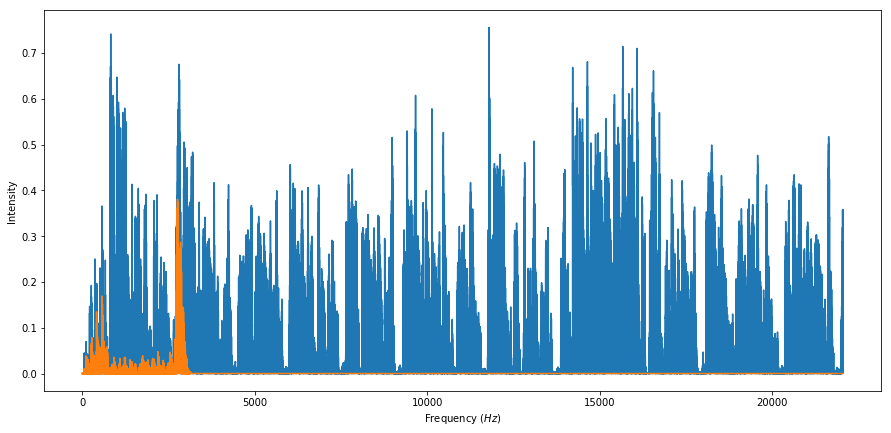


Audio 2


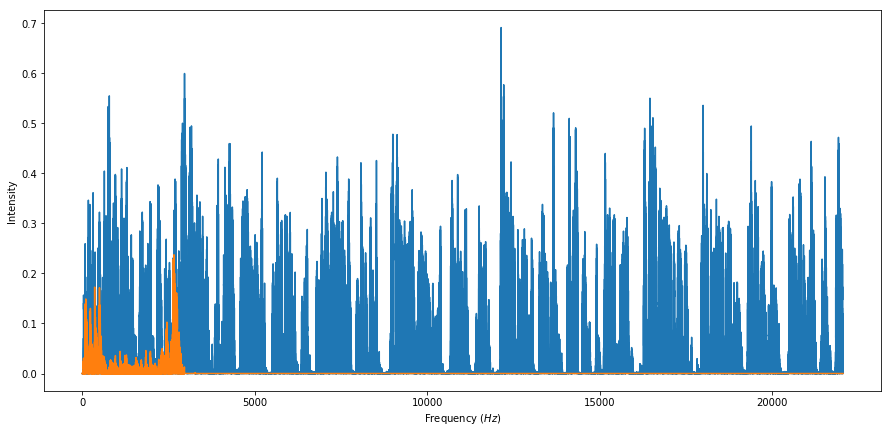


Audio 3


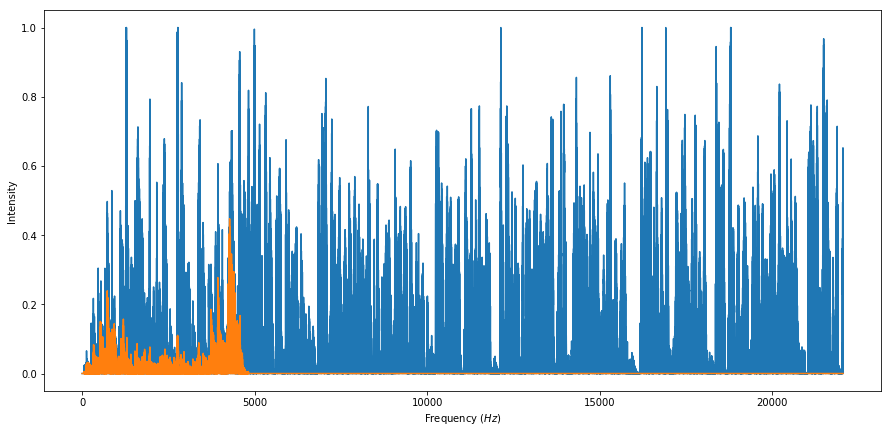

In [7]:
# Get the frequency distribution of Christopher Intagliata
print('Audio 1')
freq_c1 = freq_plt(selected[0])
print()
print('Audio 2')
freq_c2 = freq_plt(selected[2])
print()
print('Audio 3')
freq_c3 = freq_plt(selected[3])

Audio 4


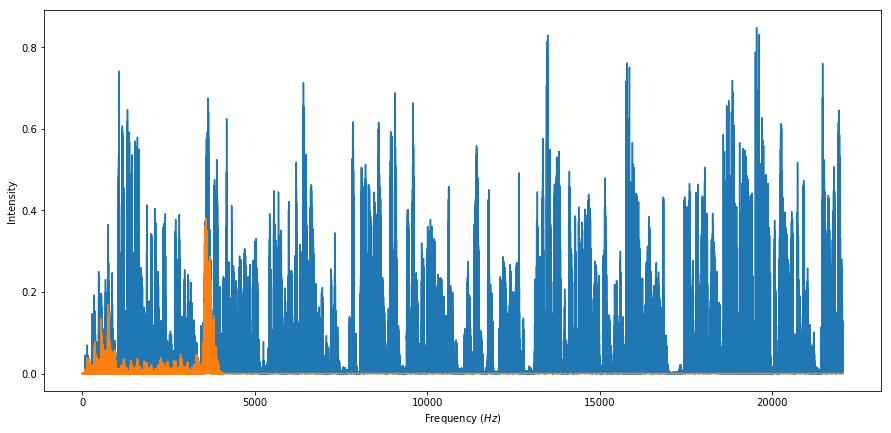


Audio 5


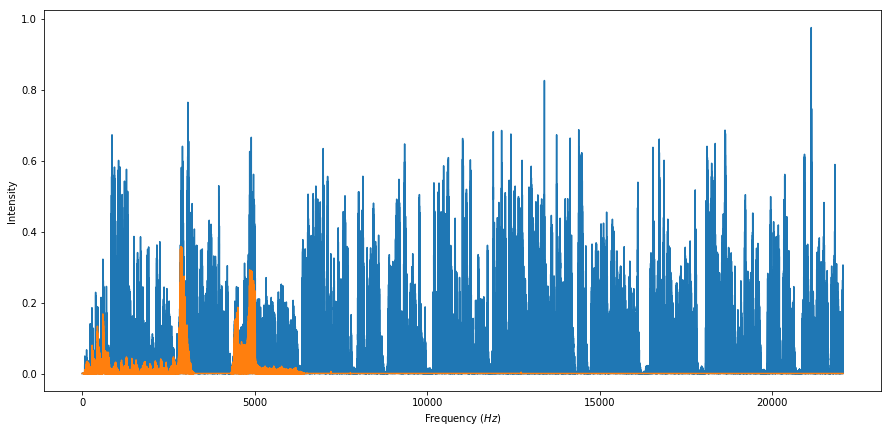

In [8]:
# Get the frequency distribution of Christopher Intagliata
print('Audio 4')
freq_c4 = freq_plt(selected[4])
print()
print('Audio 5')
freq_c5 = freq_plt(selected[5])

Audio 1


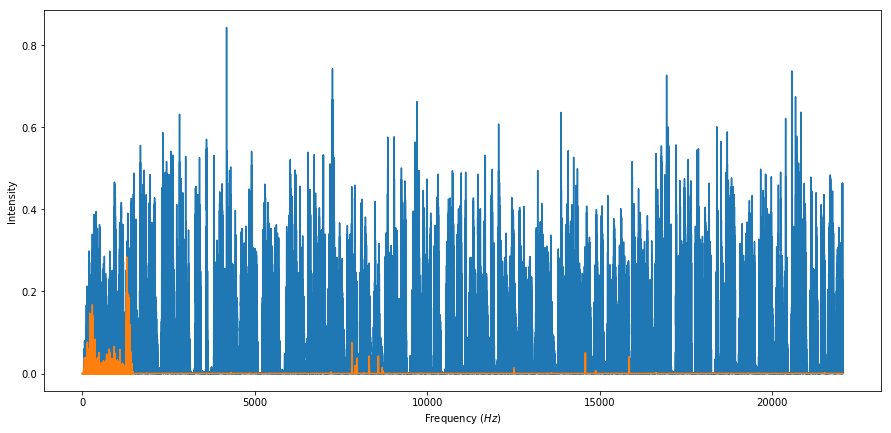


Audio 2


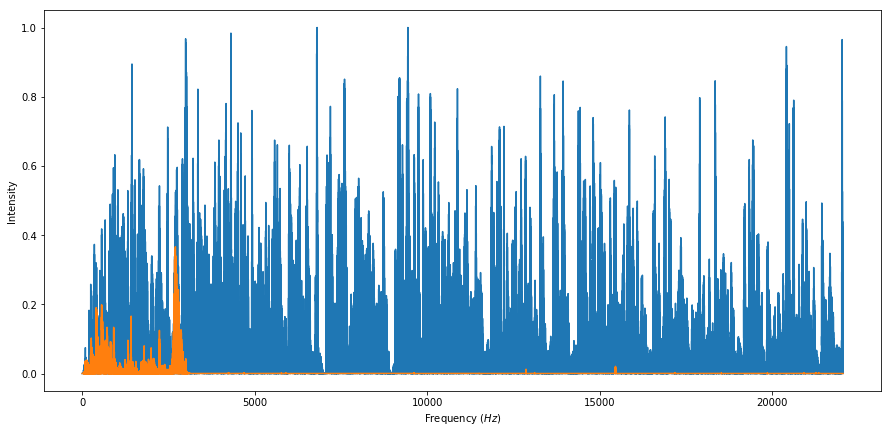

In [9]:
# Get the frequency distribution of Steve Mirsky
print('Audio 1')
freq_c6 = freq_plt(selected[1])
print()
print('Audio 2')
freq_c7 = freq_plt(selected[6])

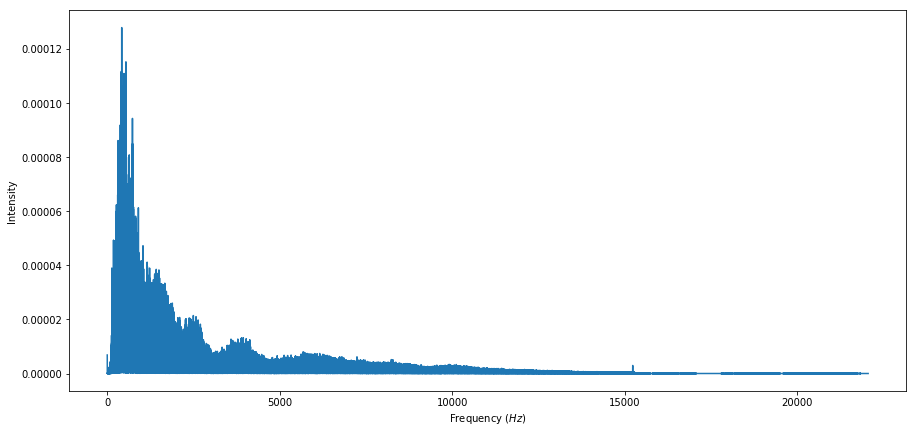

In [10]:
# Get the frequency distribution of class
freq_c8 = freq_plt(selected[7])

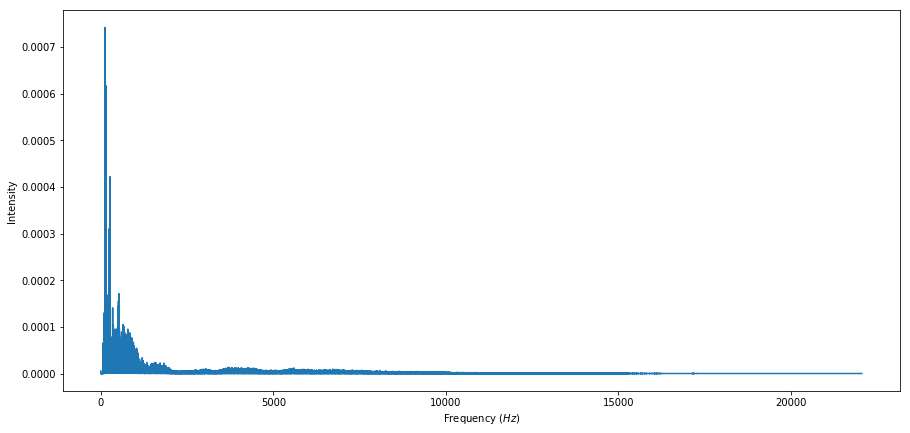

In [11]:
# Get the frequency distribution of myself
freq_c9 = freq_plt(selected[8])

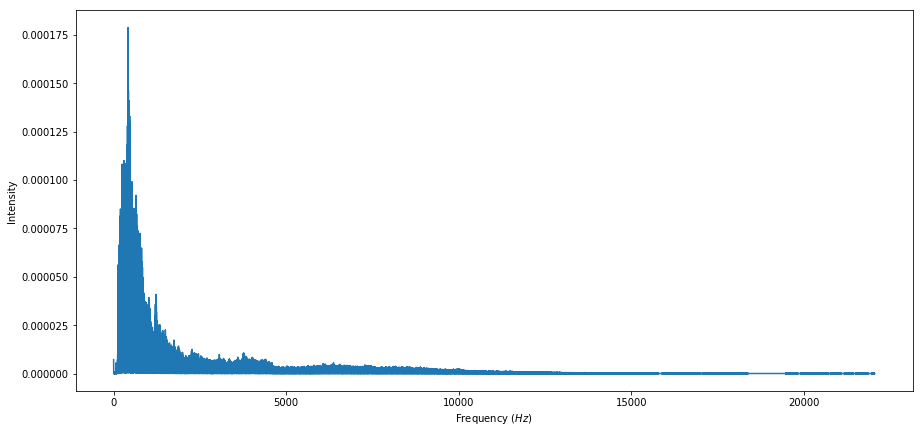

In [22]:
# Get the frequency distribution of conversation between professor and me during office hour
freq_c10 = freq_plt(selected[9])

<span style='color:blue'> Since 60 Second Science has some sounds for opening in the background, and it sometimes include recordings of interviewees, we could see two sound tracks in the plots for 60 Second Science. Both of the radio hosts has very constant frequency and intensity distribution. That means they have a great balance in speaking. Either Christopher or Steve has very stable performance, according to their plots. And their plots are similar to each other. This means they receive similar training, they have similar performance, and the product of the radio show has very stable standard.</span>

<span style='color:blue'> The professor has higher frequency than me. But his intensity is lower, maybe due to the reason that he was farther from the cellphone. The last plot show that neither the cellphone nor the algorithm could differentiate our voice, so they mix our voice together to calculate the frequency and the intensity. Compare to our individual recording, the conversation recording has medium frequency and medium intensity.</span>

<span style='color:blue'> The questions in this part are very hard to answer with my audio data.</span>

## Speech-to-Text

We can also do speech recognition on audio, but this requires a complex machine learning system. Luckily there are many online services to do this. We have a function that uses Google's API. There are two API's: one is free but limited; the other is commercial and you can provide the function `speechRec` with a file containing the API keys, using `jsonFile=` if you wish. For more about this look [here](https://stackoverflow.com/questions/38703853/how-to-use-google-speech-recognition-api-in-python) or the `speech_recognition` [docs](https://github.com/Uberi/speech_recognition).

In [18]:
#Using another library so we need to use files again
def speechRec(targetFile, language = "en-US", raw = False, jsonFile = ''):
    r = speech_recognition.Recognizer()
    if not os.path.isfile(jsonFile):
        jsonString = None
    else:
        with open(jsonFile) as f:
            jsonString = f.read()
    with speech_recognition.AudioFile(targetFile) as source:
        audio = r.record(source)
    try:
        if jsonString is None:
            print("Sending data to Google Speech Recognition")
            dat =  r.recognize_google(audio)
        else:
            print("Sending data to Google Cloud Speech")
            dat =  r.recognize_google_cloud(audio, credentials_json=jsonString)
    except speech_recognition.UnknownValueError:
        print("Google could not understand audio")
    except speech_recognition.RequestError as e:
        print("Could not request results from Google service; {0}".format(e))
    else:
        print("Success")
        return dat

The example above is of too low quality so we will be using another file `data/audio_samples/english.wav`

In [ ]:
#IPython.display.Audio('../data/audio_samples/english.wav')

In [ ]:
speechRec('../data/audio_samples/english.wav')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that use the 10 audio files from at least two different speakers read in previously, attempt to automatically extract the words from Google, and calculate the word-error rate, as descibed in Chapter 9 from *Jurafsky & Martin*, page 334. How well does it do? Under what circumstances does it perform poorly? 

In [27]:
dir_short = '/Users/hsswyx/Desktop/content_analysis/content-analysis-2018/9-Beyond-Text/wav_short'
short_lst = os.listdir(dir_short)
short_lst

['20171124sa_tech_c.wav',
 '20171220sa_tech_s.wav',
 '20180203sa_science_k.wav',
 '20180215sa_science_c.wav',
 '20180216sa_science_a.wav',
 '20180222sa_science_c.wav',
 '20180227sa_earth_c.wav',
 '20180228sa_earth_c.wav',
 '20180301sa_tech_c.wav',
 '20180302sa_earth_s.wav']

In [28]:
speech = []

for i in range(len(short_lst)):
    audio_path = dir_short + '/' + short_lst[i]
    temp_speech = speechRec(audio_path, jsonFile='speech_key')
    speech.append(temp_speech)

Sending data to Google Cloud Speech
Success
Sending data to Google Cloud Speech
Success
Sending data to Google Cloud Speech
Success
Sending data to Google Cloud Speech
Success
Sending data to Google Cloud Speech
Success
Sending data to Google Cloud Speech
Success
Sending data to Google Cloud Speech
Success
Sending data to Google Cloud Speech
Success
Sending data to Google Cloud Speech
Success
Sending data to Google Cloud Speech
Success


In [30]:
# Get the original transcript by human
dir_transcript = '/Users/hsswyx/Desktop/content_analysis/content-analysis-2018/9-Beyond-Text/transcript'
transcript_lst = os.listdir(dir_transcript)[1:]
print(len(transcript_lst))

transcripts = []
for i in range(len(transcript_lst)):
    text = ''
    with open(dir_transcript+'/'+transcript_lst[i]) as f:
        for line in f:
            line = line.strip('/\ufeff')
            text = text.strip() + '/' + line.strip()
    transcripts.append(text)

10


In [31]:
# Compare the returned transcript and the original human transcript: speech0
print('Transcribed by Google:')
print(speech[0])
print()
print('Original transcript:')
print(transcripts[0])

Transcribed by Google:
there are now more than 16 million Bitcoins in circulation with a total market cap of 130 billion dollars that's more than the market value of Netflix Priceline or Starbucks 

Original transcript:
/How Fit Is Bitcoin?/There are now more than 16 million bitcoins in circulation, with a total market cap of 130 billion dollars—more than the market value of Netflix, Priceline or Starbucks. Just going by numbers, bitcoin is the one coin to rule them all./But if you consider the spectrum of 600 actively traded cryptocoins as a financial ecosystem…you can take an evolutionary approach, and ask: which is the 'fittest' of the coins?/Or, in other words: "Every cryptocurrency, bitcoin, ethereum, there are many…are a different species." Andrea Baronchelli, a network scientist at City, University of London./He and his team used evolutionary models to approximate the real-world behavior of cryptocurrencies. Each week of currency trading was treated as a new generation of progen

In [32]:
# Compare the returned transcript and the original human transcript: speech1
print('Transcribed by Google:')
print(speech[1])
print()
print('Original transcript:')
print(transcripts[1])

Transcribed by Google:
for us to use this magical power of invention and Innovation to change the lives of people's really needed 

Original transcript:
/Tech Honcho Wants Innovation for the Bottom Billion/“I think it’s really important for us to use this magical power of invention and innovation to change the lives of people who really needed their lives changed.”/Nathan Myhrvold, co-founder of the technology development company Intellectual Ventures. He was formerly Chief Technology Officer at Microsoft. He spoke at the World Conference of Science Journalists in San Francisco October 28th./“People at the bottom billion in the world from, well, from any perspective. You can look at the bottom billion from health care or from poverty, it’s pretty much the same folks. And those are people who need their lives transformed. But the iPhone X isn’t how to do that. You need to have other kinds of technology that will focus, and try to make a magical solution to what’s otherwise an intractabl

In [33]:
# Compare the returned transcript and the original human transcript: speech2
print('Transcribed by Google:')
print(speech[2])
print()
print('Original transcript:')
print(transcripts[2])

Transcribed by Google:
there's a holiday that goes hand-in-hand with romance so much so that nine months later there's a spike in the number of babies born Valentine's Day wrong 

Original transcript:
/Holiday Cheer Leads to Birth-Rate Spike/In the United States, there’s a holiday that goes hand in hand with romance. So much so that nine months later, there’s a spike in the number of babies born. Valentine’s day? Wrong! It seems that people in the U.S. and in other predominantly Christian countries have been having some very merry Christmases indeed. That’s according to a study in the journal Scientific Reports./Scientists have long wondered why, in Western countries, birth rates spike in September and early October.“The prevailing hypothesis for this phenomenon postulates that there is a biological adaptation to the solar cycles.”Luis Rocha of Indiana University co-led the study. He notes that nine months before this baby boomlet is the winter solstice. And when the days grow shorter 

In [34]:
# Compare the returned transcript and the original human transcript: speech3
print('Transcribed by Google:')
print(speech[3])
print()
print('Original transcript:')
print(transcripts[3])

Transcribed by Google:
antibiotics are no Silver Bullet in fact if you get him in the hospital you may end up with an additional infection 

Original transcript:
/Fecal Transplanters Fish Out Key Ingredient/These days, antibiotics are no silver bullet. In fact, if you get them in the hospital, you may end up with an additional infection. Like the bug Clostridium difficile, or C. diff—which infects more than 300,000 Americans a year and kills some 14,000.C. diff flourishes in the post-antibiotic, microbe-free landscape of your gut. But there is a way to stop it—a fecal transplant. That cocktail of microbes from a healthy person's gut can rein in a C. diff outbreak. The question is not: Eewww? It’s: What are the transplant's active ingredients? You can find more 60-Second science on chinavoa.com./Well, one of them appears to be a bacterium calledClostridium scindens. Because in past studies, people and mice that harbored C. scindens were protected against a full-blownC. diff infection. S

In [35]:
# Compare the returned transcript and the original human transcript: speech4
print('Transcribed by Google:')
print(speech[4])
print()
print('Original transcript:')
print(transcripts[4])

Transcribed by Google:
kids from different economic backgrounds behave differently in classrooms for example working class kids are low 

Original transcript:
/Poorer Kids May Be Too Respectful at School/Kids from different economic backgrounds behave differently in classrooms. For example, working class kids are less likely to ask for help from teachers than are their middle class counterparts. And when they do ask for help, they’re less aggressive about it. That’s according to a study that followed students from the third grade through the fifth, published in the journal American Sociological Review./Part of the difference in how kids act comes from the guidance they’ve gotten at home. As a rule, working class parents coach their kids to work out problems on their own. And if the kids did ask for help, it was in subtle ways—like sitting quietly with a hand raised. Middle class kids? Their parents urged them to be proactive, even to interrupt their teachers for help./The result is tha

In [36]:
# Compare the returned transcript and the original human transcript: speech5
print('Transcribed by Google:')
print(speech[5])
print()
print('Original transcript:')
print(transcripts[5])

Transcribed by Google:
what are the drawbacks of researching blue whales is that most of the time you can't see what your study subjects doing or how many there are or even where they are 

Original transcript:
/Undersea Recordings Reveal a Whale's Tale/One of the drawbacks of researching blue whales is that most of the time you can't see what your study subjects are doing, or how many there are—or even, where they are. Satellite tags have revealed some of their diving behavior and where they migrate. But tags will never give a complete picture of the population at large./"Because it's really hard to fit a tag on a whale." Ana Širović, an oceanographer at the Scripps Institution of Oceanography. "We have 121 tags that have been deployed on blue whales. And we're talking about 16 or so years of field work. So it's not realistic to think we can just go out and tag all the animals and figure out that way how many there are."/But Širović is using another method to track the underwater gian

In [37]:
# Compare the returned transcript and the original human transcript: speech6
print('Transcribed by Google:')
print(speech[6])
print()
print('Original transcript:')
print(transcripts[6])

Transcribed by Google:
humans can recognize each other by voice alone I sound different from other 60 second science to borders for example 

Original transcript:
/Woodpeckers Drum to Their Own Tunes/Humans can recognize each other by voice alone. I sound different from other 60-Second Science reporters, for example. In fact, lots of nonhuman animals, of all types, use voices to distinguish familiar individuals…including frogs, fish, lemurs, and penguins./And that unique audio fingerprint extends to a sound you may have heard in the forest on occasion: ...the drumming of a woodpecker./Researchers recorded multiple drum rolls, <> from 41 great spotted woodpeckers—colorful red, white and black birds—living in Polish forests. They then used audio software to analyze them./And they found that the length of the drumrolls, and the spacing between beats varied enough from bird to bird to tell the woodpeckers apart by drumming alone. The study is in the journal PLOS ONE./The scientists say thi

In [38]:
# Compare the returned transcript and the original human transcript: speech7
print('Transcribed by Google:')
print(speech[7])
print()
print('Original transcript:')
print(transcripts[7])

Transcribed by Google:
the fires that ripped across Napa and Sonoma last year damage some two dozen wineries completely to the ground 

Original transcript:
/Wildfires Spike Wine with Smoky Notes/The fires that ripped across Napa and Sonoma last year damaged some two dozen wineries, and burned others completely to the ground./"Yeah and also don't forget Chile burned pretty good this year, too. In fact fires there destroyed quite a few old vineyards." Wes Zandberg, an analytical chemist at the University of British Columbia, at the Okanagan campus, right in B.C.'s wine country. "Basically this is a problem in North and South America this year."/Even wineries that are unscathed by fire may suffer from smoke passing through their vineyards. Because it can leave that year's vintage with unpleasant smoky notes./Zandberg and his team studied that process with an experimental plot of cabernet franc vines—five of which they exposed to wood smoke, and five they left alone./They found that when 

In [39]:
# Compare the returned transcript and the original human transcript: speech8
print('Transcribed by Google:')
print(speech[8])
print()
print('Original transcript:')
print(transcripts[8])

Transcribed by Google:
walking in New York City is almost a competitive sport 

Original transcript:
/Big Cities Have Fewer Tweeters Per Capita/Walking in New York City is almost a competitive sport. <> And people in cities really do walk faster than their country counterparts—2.8 feet per second faster, according to a worldwide study in the 1970s. But that speedier pace of life extends to other aspects of city living, too./"There's more inventions per capita in large cities, there's more mobile telephony usage in large cities." Lav Varshney, an information theorist at the University of Illinois at Urbana–Champaign./He says you might expect Twitter use to increase in larger cities, too. But after analyzing two and a half million tweets, from 50 U.S. cities, his team concluded the opposite is true: There's actually less tweeting per capita as population rises./But those who do tweet in big cities are more prolific—tweeting more often, on average, than their small-town counterparts. "And

In [40]:
# Compare the returned transcript and the original human transcript: speech9
print('Transcribed by Google:')
print(speech[9])
print()
print('Original transcript:')
print(transcripts[9])

Transcribed by Google:
Define the composition of ecosystems around the world is changing much more rapidly than we expected on the indeed much more rapidly than ecological theory predicts 

Original transcript:
/Needed: Info on Biodiversity Change over Time/“We find that the composition of ecosystems around the world is changing much more rapidly than we expected. Indeed, much more rapidly than ecological theory predicts.”/Biologist Anne Magurran of the University of Saint Andrews in Scotland./“We still don’t understand the consequences of this. We think that it’s going to be associated with a reduction in resilience in these assemblages, but there are still many questions to be addressed about the consequences of this rapid biodiversity change. And what it means is that if we’re interested in conservation we need to do much more than count species. We also need to track changes in the abundances and identities of the species present in these ecosystems. Conservation biologists will ne

In [42]:
total_words = 0
for i in range(len(speech)):
    temp = len(speech[i].split())
    total_words += temp
total_words

221

In [43]:
# And as I manually compare the Google transcripts and the human transcripts, 
# and the original audio, there are 9 errors. So the error rate is:
9/221

0.04072398190045249

<span style='color:blue'> The error rate is approximately 4.072%, which means the Google speech recognition performs very well. It works perfectly in most cases.</span>

<span style='color:blue'> But it does not perform well when the speaker talk too quickly or too vaguely. For example, when the speaker speaks too quickly with 'and indeed', the Google only recognized 'indeed'. Another example, Google gives me "what are the drawbacks of researching blue whales is that most of the time you can't see what your study subjects doing or how many there are or even where they are ". Actually, this sentence starts with 'One of'. In a real research, if the ignored words contain important information, then we may lose some critical points in the speeches.</span>

<span style='color:blue'> Also, the machine does not work well in tone recognition, and cutting words in separated sentences. For example, it gives me the words "there's a holiday that goes hand-in-hand with romance so much so that nine months later there's a spike in the number of babies born Valentine's Day wrong". However, there's some tone in the original audio in "...babies born. Valentine's Day? Wrong!". While human transcribers could seperate the words very well, the machine seems to treat it as plain statement without any stop. For another example, it gives me "humans can recognize each other by voice alone I sound different from other 60 second science to borders for example". But it woule be hard for me to understand if there are more words without any punctuation.</span>

<span style='color:blue'> In brief, machine could be helpful in quickly transcribing audio records for us. But we still need human to punctuate the plain words by understading the emotions. At least, we need human to look at both plain transcripts given by the machine and frequency & intensity distribution to understand human speeches better.</span>

# Image analysis

Now we will explore image files. First, we will read in a couple of images. Please change the working image and see how the resuts differ:

In [ ]:
image_wiki = PIL.Image.open('../data/Wikimedia_Conference_2016_–_Group_photo.jpg')
image_wikiGray = PIL.ImageOps.invert(image_wiki.convert('L'))

image_AllSaints = PIL.Image.open('../data/AllSaintsMargaretStreet-DAVID_ILIFF.jpg')
image_AllSaintsGray = PIL.ImageOps.invert(image_AllSaints.convert('L'))

image_Soyuz = PIL.Image.open('../data/Soyuz.jpg')
image_SoyuzGray = PIL.ImageOps.invert(image_Soyuz.convert('L'))

image_Rock = PIL.Image.open('../data/Bi-crystal.jpg')
image_RockGray = PIL.ImageOps.invert(image_Rock.convert('L'))

image_flowers = PIL.Image.open('../data/flowers.jpg')
image_flowersGray = PIL.ImageOps.invert(image_flowers.convert('L'))

image = image_flowers

image

In [ ]:
imageArr = np.asarray(image)
imageArr.shape

The image we have loaded is a raster image, meaning it is a grid of pixels. Each pixel contains 1-4 numbers giving the amounts of color contained in it. In this case, we can see it has 3 values per pixel, these are RGB or Red, Green and Blue values. If we want to see just the red, we can look at just that array:

In [ ]:
imgRatio = imageArr.shape[0] / imageArr.shape[1]
fig, ax = plt.subplots(figsize = (15, 15))
ax.imshow(imageArr[:,:,0], cmap='Reds') #The order is R G B, so 0 is the Reds
ax.axis('off')
plt.show()

Or the others:

In [ ]:
imgRatio = imageArr.shape[0] / imageArr.shape[1]
fig, ax = plt.subplots(figsize = (15, 15))
ax.imshow(imageArr[:,:,1], cmap='Greens') #The order is R G B, so 2 is the Green
ax.axis('off')
plt.show()

In [ ]:
imgRatio = imageArr.shape[0] / imageArr.shape[1]
fig, ax = plt.subplots(figsize = (15, 15))
ax.imshow(imageArr[:,:,2], cmap='Blues') #The order is R G B, so 2 is the Blue
ax.axis('off')
plt.show()

Or we can look at all four together:

In [ ]:
fig, axes = plt.subplots(figsize = (10, 10), ncols=2, nrows=2)
axeIter = iter(axes.flatten())
colours = ["Reds", "Greens", "Blues"]
ax = next(axeIter)
ax.imshow(imageArr)
ax.axis('off')

for i in range(3):
    ax = next(axeIter)
    ax.imshow(imageArr[:,:,i], cmap=colours[i]) #The order is R G B, so 2 is the Blue
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
image_gray = PIL.ImageOps.invert(image.convert('L'))
image_grayArr = np.asarray(image_gray)
image_grayArr.shape

A grayscale image is defined by its pixel intensities (and a color image can be defined by its red, green, blue pixel intensities).

In [ ]:
imgRatio = imageArr.shape[0] / imageArr.shape[1]
fig, ax = plt.subplots(figsize = (15, 15))
ax.imshow(image_grayArr) #No third dimension
ax.axis('off')
plt.show()

## Blob Detection

Recall our earlier use of scikit-learn for machine learning. Now we will use scikit-image to do some simple image processing. Here we will perform three operations for 'blob' of simple object detection. In computer vision, blob detection methods aim to detect regions in a digital image that differ in properties, such as brightness or color, compared to surrounding regions. Informally, a blob is a region of an image in which some properties are approximately constant or similar to each other. We will do this in three ways.

First, we will take the Laplacian of an image, which is a 2-D isotropic (applying equally well in all directions) measure of the 2nd spatial derivative of an image. The Laplacian of an image highlights regions of rapid intensity change and is therefore often used for edge detection. This Laplacian is taken of the image once a Gaussian smoothing filter has been applied in order to reduce its sensitivity to noise.

The Laplacian $L(x,y)$ of an image with pixel intensity values $I(x,y)$ is given by: $L(x,y)=\frac{\delta^2x}{\delta x^2} + \frac{\delta^2y}{\delta y^2}$. A Gaussian smoothing filter takes a 2 dimensional Guassian, $G(x,y)=\frac{1}{2 \pi \sigma^2} e^\frac{-x^2 + y^2}{2\sigma^2}$, which looks like: <img src="http://www.librow.com/content/common/images/articles/article-9/2d_distribution.gif">

This Gaussian *kernel* is applied to the pixel intensities of the image via *convolution* -- the kernel is multiplied by the pixel intensities, while centered on each pixel, then added.

The blob detector computes the [Laplacian of Gaussian (LoG)](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_log) images with successively increasing standard deviation and stacks them up in a cube. Blobs are local maximas within this cube. Detecting larger blobs is slower because of larger kernel sizes during convolution. Bright blobs on dark backgrounds are detected.

In [ ]:
blobs_log = skimage.feature.blob_log(image_grayArr, max_sigma=30, num_sigma=5, threshold=.1)
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2) #Radi
fig, ax = plt.subplots(figsize = (15, 15))
ax.axis('off')

plt.imshow(image_grayArr, interpolation='nearest')
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, linewidth=2, fill=False)
    ax.add_patch(c)

Second, we look at [Difference of Gaussian (DoG)](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_dog), a much faster approximation of the LoG approach in which an image is blurred with increasing standard deviations and the difference between two successively blurred images are stacked up in a cube. 

In [ ]:
blobs_dog = skimage.feature.blob_dog(image_grayArr, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)
fig, ax = plt.subplots(figsize = (15, 15))
ax.axis('off')

plt.imshow(image_grayArr, interpolation='nearest')
for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r, linewidth=2, fill=False)
    ax.add_patch(c)

Finally, we consider the [Determinant of Hessian (DoH)](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_doh) approach. The Hessian matrix or Hessian is a square matrix of second-order partial derivatives $\frac{\partial^2 f}{\partial x_i \partial x_j}(x_1^{*}, \ldots, x_n^{*})$ and is calculated on square pixel patches of the image. The determinant is the scaling factor of each patch. This approach is fastest and detects blobs by finding maximas in this matrix (of the Determinant of the Hessian of the image). Detection speed is independent of the size of blobs as the implementation uses box filters, $\begin{bmatrix}1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1\end{bmatrix}$, instead of Gaussians for the convolution. As a result, small blobs (< 3 pixels) cannot be detected accurately. 

In [ ]:
blobs_doh = skimage.feature.blob_doh(image_grayArr, max_sigma=30, threshold=.01)
fig, ax = plt.subplots(figsize = (15, 15))
ax.axis('off')

plt.imshow(image_grayArr, interpolation='nearest')
for blob in blobs_doh:
    y, x, r = blob
    c = plt.Circle((x, y), r, linewidth=2, fill=False)
    ax.add_patch(c)

Humans possess an incredible ability to identify objects in an image. Segmentation is the process of dividing an image into meaningful regions. All pixels belonging to a region should receive a unique label in an ideal segmentation.

Region Adjacency Graphs (RAGs) are a common data structure for many segmentation algorithms. First, we define regions through the SLIC algorithm that assigns a unique label to each region or a localized cluster of pixels sharing some similar property (e.g., color or grayscale intensity). Then we'll consider each region a node in a graph, and construct a region boundary RAG, where the edge weight between two regions is the average value of the corresponding pixels in edge_map along their shared boundary. Then edges below a specified threshold are removed and a connected component is labeled as one region. 

In [ ]:
labels = skimage.segmentation.slic(image_grayArr, compactness=30, n_segments=400)
g = skimage.future.graph.rag_mean_color(image_grayArr, labels)
fig, ax = plt.subplots(figsize = (15, 15))
ax.axis('off')
lc = skimage.future.graph.show_rag(labels, g, image_grayArr, ax = ax)

Interesting boundaries were constructed for this image.

We can generalize many of the approaches into a collection of kernel methods. These are also how Convolutional Neural Networks (CNNs) create their features:

In [ ]:
def normalizeConvo(a_c):
    s = np.sum(a_c.flatten())
    return a_c / s

def displayConvolution(img, convArray, threshold = None):
    img_array = np.asarray(img).astype('uint8')
    
    if len(img_array.shape) > 2:
        conv = np.zeros(img_array.shape)
        for i in range(img_array.shape[2]):
            conv[:,:,i] = scipy.ndimage.convolve(img_array[:,:,i], normalizeConvo(convArray), mode='constant')
    else:
        conv = scipy.ndimage.convolve(img_array, normalizeConvo(convArray), mode='constant')
    conv = conv.astype('uint8')
    if threshold is not None:
        if threshold < 1:
            threshold = threshold * 255
        conv[conv < threshold] = 0
    
    conv_image = PIL.Image.fromarray(conv)
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (17, 10))
    #This is to deal with some annoying plt/PIL stuff
    if len(img_array.shape) > 2:
        ax1.imshow(img)
    else:
        ax1.imshow(img_array)
    ax1.axis('off')
    ax1.set_title("Original")
    #return conv_image
    if len(img_array.shape) > 2:
        ax2.imshow(conv_image)
    else:
        ax2.imshow(np.asarray(conv_image))
    ax2.axis('off')
    ax2.set_title("Convolution")
    
    diff = PIL.ImageChops.difference(conv_image, img)
    if len(img_array.shape) > 2:
        ax3.imshow(diff)
    else:
        ax3.imshow(np.asarray(diff))
    ax3.axis('off')
    ax3.set_title("Difference")
    plt.tight_layout()
    plt.show()
    #Not returning anything to make displaying nicer

[Here](https://en.wikipedia.org/wiki/Kernel_(image_processing%29) are a fistfull kenels to try. In image processing, kernels (also convolution matrices or masks) are small matrices. They are used for blurring, sharpening, edge detection, and more. This is accomplished by doing a convolution between a kernel and an image by adding each element of the image to its local neighbors, weighted by the kernel, as shown below:

In [ ]:
smoothingKernel = np.array([
    [1, 1, 1],
    [1, 2, 1],
    [1, 1, 1]])
c = displayConvolution(image_gray, smoothingKernel)

In [ ]:
verticalLineKernel = np.array([
    [1, 0, -1],
    [0, 8, 0],
    [1, 0, -1]])
displayConvolution(image, verticalLineKernel, threshold=.6)

In [ ]:
diagonalLineKernel = np.array([
    [-1, 0, -1],
    [0, 8, 0],
    [1, 0, -1]])
displayConvolution(image, diagonalLineKernel, threshold=.6)

In [ ]:
blurKernel = np.array([
    [1, 2, 4, 2, 1],
    [2, 4, 8, 4, 2],
    [4, 8, 16, 8, 4],
    [2, 4, 8, 4, 2],
    [1, 2, 4, 2, 1]])
displayConvolution(image, blurKernel)

In [ ]:
SharpenKernel = np.array([
    [ 0,  0,  -1,  0,  0],
    [ 0, -1,  -2, -1,  0],
    [-1, -2,  20, -2, -1],
    [ 0, -1,  -2, -1,  0],
    [ 0,  0,  -1,  0,  0]])
displayConvolution(image, SharpenKernel)

In [ ]:
differentKernel = np.array([
    [ 1, 0,  0, 0,  -1],
    [ 1, 0,  0, 0,  -1],
    [ 1, 0,  1, 0,  -1],
    [ 1, 0,  0, 0,  -1],
    [ 1, 0,  0, 0,  -1]])
#This looks neat
displayConvolution(image, differentKernel)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that read in 10 image files (e.g., produced on your smartphone, harvested from the web, etc.) that feature different kinds of objects and settings, including at least one indoor and one outdoor setting. Perform blob detection and RAG segmentation using the approaches modeled above. How well does each algorithm identify objects or features of interest?

### <span style="color:blue"> Image Data

In [ ]:
# Get image data ready
dir_image = '/Users/hsswyx/Desktop/content_analysis/content-analysis-2018/9-Beyond-Text/image'
images = os.listdir(dir_image)[1:]

image_lst = []
for i in range(len(images)):
    image_path = dir_image + '/' + images[i]
    image = PIL.Image.open(image_path)
    image_Gray = PIL.ImageOps.invert(image.convert('L'))
    imageArr = np.asarray(image)
    image_grayArr = np.asarray(image_Gray)
    temp = [image, image_Gray, imageArr, image_grayArr]
    image_lst.append(temp)

### <span style='color:blue'> Blobs Detection

In [ ]:
# Define my own function for blobs detection
def blobs_plt(image_grayArr, algorithm):
    if algorithm == 'log':
        blobs_data = skimage.feature.blob_log(image_grayArr, max_sigma=30, num_sigma=5, threshold=.1)
        blobs_data[:, 2] = blobs_data[:, 2] * np.sqrt(2) #Radi
    elif algorithm == 'dog':
        blobs_data = skimage.feature.blob_dog(image_grayArr, max_sigma=30, threshold=.1)
        blobs_data[:, 2] = blobs_data[:, 2] * np.sqrt(2)
    else:
        blobs_data = skimage.feature.blob_doh(image_grayArr, max_sigma=30, threshold=.01)

    fig, ax = plt.subplots(figsize = (15, 15))
    ax.axis('off')
    
    plt.imshow(image_grayArr, interpolation='nearest')
    for blob in blobs_data:
        y, x, r = blob
        c = plt.Circle((x, y), r, linewidth=2, fill=False)
        ax.add_patch(c)

In [ ]:
# Image 1: ourdoor animal with 'LOG'
blobs_plt(image_lst[0][3], 'log')

In [ ]:
# Image 1: outdoor animal with 'DOG'
blobs_plt(image_lst[0][3], 'dog')

In [ ]:
# Image 1: outdoor animal with 'DOH'
blobs_plt(image_lst[0][3], 'doh')

<span style='color:blue'> The 'LOG' sees things that have significantly different color from the other parts. The 'DOG' sees things that have even slight different color from the others, very sentive. The 'DOH' only looks at the the most different item. So in the order of sensitivity, 'DOG' > 'LOG' > 'DOH'. We could decide which one we should use based on our requirement of computing speed and sensitivity.

In [ ]:
# Image 2: indoor myself with toy dog
blobs_plt(image_lst[1][3], 'log')

In [ ]:
# Image 2: indoor myself with toy dog
blobs_plt(image_lst[1][3], 'dog')

In [ ]:
# Image 2: indoor myself with toy dog
blobs_plt(image_lst[1][3], 'doh')

In [ ]:
# Image 3: outdoor Uchicago
blobs_plt(image_lst[2][3], 'log')

In [ ]:
# Image 3: outdoor Uchicago
blobs_plt(image_lst[2][3], 'dog')

In [ ]:
# Image 3: outdoor Uchicago
blobs_plt(image_lst[2][3], 'doh')

In [ ]:
# Image 4: indoor dumpling
blobs_plt(image_lst[3][3], 'log')

In [ ]:
# Image 4: indoor dumpling
blobs_plt(image_lst[3][3], 'dog')

In [ ]:
# Image 4: indoor dumpling
blobs_plt(image_lst[3][3], 'doh')

In [ ]:
# Image 5: indoor supermarket
blobs_plt(image_lst[4][3], 'log')

In [ ]:
# Image 5: indoor supermarket
blobs_plt(image_lst[4][3], 'dog')

In [ ]:
# Image 5: indoor supermarket
blobs_plt(image_lst[4][3], 'doh')

In [ ]:
# Image 6: indoor soup
blobs_plt(image_lst[5][3], 'log')

In [ ]:
# Image 6: indoor soup
blobs_plt(image_lst[5][3], 'dog')

In [ ]:
# Image 6: indoor soup
blobs_plt(image_lst[5][3], 'doh')

In [ ]:
# Image 7: indoor chip
blobs_plt(image_lst[6][3], 'log')

In [ ]:
# Image 7: indoor chip
blobs_plt(image_lst[6][3], 'dog')

In [ ]:
# Image 7: indoor chip
blobs_plt(image_lst[6][3], 'doh')

In [ ]:
# Image 8: indoor animal
blobs_plt(image_lst[7][3], 'log')

In [ ]:
# Image 8: indoor animal
blobs_plt(image_lst[7][3], 'dog')

In [ ]:
# Image 8: indoor animal
blobs_plt(image_lst[7][3], 'doh')

In [ ]:
# Image 9: indoor book stack
blobs_plt(image_lst[8][3], 'log')

In [ ]:
# Image 9: indoor book stack
blobs_plt(image_lst[8][3], 'dog')

In [ ]:
# Image 9: indoor book stack
blobs_plt(image_lst[8][3], 'doh')

In [ ]:
# Image 10: indoor weeding scene
blobs_plt(image_lst[9][3], 'log')

In [ ]:
# Image 10: indoor weeding scene
blobs_plt(image_lst[9][3], 'dog')

In [ ]:
# Image 10: indoor weeding scene
blobs_plt(image_lst[9][3], 'doh')

<span style='color:blue'> After checking all the images with all the algorithms above, I find the rule of sensitivity is consistent. Generally, in every set of images, we could see in the order of number of points of interest, we have 'DOG' > 'LOG' > 'DOH'. In other words, in the sense of sensitivity, we have 'DOG' > 'LOG' > 'DOH'. However, sometimes 'LOG' could be more sensitive than 'DOG'. In Image 2 and Image 8, the 'LOG' actually see things in greater detail, while 'DOG' cares more about the outlines. For example, in Image 2, 'LOG' puts a lot of emphasis on my hair, which has very different color from surrounding items. But 'DOG' just capture the outline of my hair, and captures more other detail than the 'LOG', such as the window shades. And in Image 8, the 'LOG' sees the detailed shape of the cage in the background, while the 'DOG' only cares about whether there's something with different color.</span>

<span style='color:blue'> The 'DOH' works the worst. Maybe it is suitable to detect whether there's any things with dramatically different color from the other items in the image. The 'LOG' is suitable for the images with many details, and we want to capture the details. And the 'DOG' is suitable if we only want to capture generally everything but only the outlines.</span>

### <span style='color:blue'> RAG Segmentation

In [ ]:
# Define my own function to run all kernels at one time
def RAG_kernel(image):
    smoothingKernel = np.array([
            [1, 1, 1],
            [1, 2, 1],
            [1, 1, 1]])
    verticalLineKernel = np.array([
            [1, 0, -1],
            [0, 8, 0],
            [1, 0, -1]])
    diagonalLineKernel = np.array([
            [-1, 0, -1],
            [0, 8, 0],
            [1, 0, -1]])
    blurKernel = np.array([
            [1, 2, 4, 2, 1],
            [2, 4, 8, 4, 2],
            [4, 8, 16, 8, 4],
            [2, 4, 8, 4, 2],
            [1, 2, 4, 2, 1]])
    SharpenKernel = np.array([
            [ 0,  0,  -1,  0,  0],
            [ 0, -1,  -2, -1,  0],
            [-1, -2,  20, -2, -1],
            [ 0, -1,  -2, -1,  0],
            [ 0,  0,  -1,  0,  0]])
    differentKernel = np.array([
            [ 1, 0,  0, 0,  -1],
            [ 1, 0,  0, 0,  -1],
            [ 1, 0,  1, 0,  -1],
            [ 1, 0,  0, 0,  -1],
            [ 1, 0,  0, 0,  -1]])
    # Plot
    print('Smoothing Kernel:')
    displayConvolution(image, smoothingKernel)
    print('Vertical Line Kernel:')
    displayConvolution(image, verticalLineKernel, threshold=.6)
    print('Diagonal Line Kernel:')
    displayConvolution(image, diagonalLineKernel, threshold=.6)
    print('Blur Kernel:')
    displayConvolution(image, blurKernel)
    print('Sharpen Kernel:')
    displayConvolution(image, SharpenKernel)
    print('Different Kernel:')
    displayConvolution(image, differentKernel)

In [ ]:
# Image 1: outdoor animal
RAG_kernel(image_lst[0][0])

In [ ]:
# Image 2: indoor myself
RAG_kernel(image_lst[1][0])

In [ ]:
# Image 3: outdoor Ucnicago
RAG_kernel(image_lst[2][0])

In [ ]:
# Image 4: indoor dumpling
RAG_kernel(image_lst[3][0])

In [ ]:
# Image 5: indoor supermarket
RAG_kernel(image_lst[4][0])

In [ ]:
# Image 6: indoor soup
RAG_kernel(image_lst[5][0])

In [ ]:
# Image 7: indoor chip
RAG_kernel(image_lst[6][0])

In [ ]:
# Image 8: indoor dog
RAG_kernel(image_lst[7][0])

In [ ]:
# Image 9: indoor bookstack
RAG_kernel(image_lst[8][0])

In [ ]:
# Image 10: indoor wedding scens
RAG_kernel(image_lst[9][0])

<span style='color:blue'> Generally speaking, in the sense of difference, the Vertical Line Kernel and the Diagonal Line Kernel always performs the best. They stably keep details of images in every circumstances. But sometimes they may capture too much, making it hard to get the outline of the images.</span>

<span style='color:blue'> Also in the sense of difference, the Different Kernel does not have a stable performance over my 10 images, but it is good at capturing outlines of the images. It works well with Image 2(me & toy dog), Image 3(campus of UChicago), Image 4(dumplings), Image 5(supermarket), Image 7(chips), Image 9(bookstack), and Image 10(my friend's wedding). I think this kernel works well with images with clear shapes and constrating colors.</span>

<span style='color:blue'> Still in the sense of difference, the Sharpen Kernel sometimes work well. It works well with Image 3(campus of UChicago), Image 5(supermarket), and Image 8(corgi dog). It seems it performs well with very colorful images. For Image 8(corgi dog), it even out-performs the Different Kernel.</span>

<span style='color:blue'> The Smoothing Kernel and the Blur Kernel are good if we only look at the the results of Convolutional Neural Networks. However, in the sense of difference, they just don't provide any information. So if we only work with CNN and we don't care about difference, we should choose the Smoothing Kernel or the Blur Kernel to retain the original information.</span>

# Object Detection & Scene Classification

Modern image and video analysis is typically performed using deep learning implemented as layers of convolutional neural nets to classify scenes and to detect and label objects. To learn more about deep learning and convolutional neural networks, spend some time with Andrew Ng's excellent [tutorial](http://ufldl.stanford.edu/tutorial/). Because such algorithms require substantial computing power, none of the high-quality classifiers or detectors currently available are implemented in python, although many can be called via api. The most popular open source image object detector is UC Berkeley's [*caffe*](http://caffe.berkeleyvision.org) library of trained and trainable neural nets written in C++. (Check out the [python api](https://github.com/BVLC/caffe/blob/master/python/caffe/pycaffe.py)). Scene classifiers can be built on top of caffe, such as MIT's [Places](http://places2.csail.mit.edu/demo.html). 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that report the results from experiments in which you place each of images taken or retrieved for the last exercise through the online demos for [caffe](http://demo.caffe.berkeleyvision.org) and [places](http://places.csail.mit.edu/demo.html). Paste the image and the output for both object detector and scene classifier below, beside one another. Calculate precision and recall for caffe's ability to detect objects of interest across your images. What do you think about Places' scene categories and their assignments to your images? What would be improved labels for your images? Could you use image classification to enhance your research project and, if so, how?

### <span style='color:blue'> Results of [caffe](http://demo.caffe.berkeleyvision.org) and [places](http://places.csail.mit.edu/demo.html).

In [ ]:
# Get results stored in a csv file
caffe_df = pandas.read_csv('caffe_results.csv')

# Get pre-stored informative region
dir_info = '/Users/hsswyx/Desktop/content_analysis/content-analysis-2018/9-Beyond-Text/informative_region'
info = os.listdir(dir_info)
# collect images into a list
info_lst = []
for i in range(len(info)):
    image_path = dir_info + '/' + info[i]
    image = PIL.Image.open(image_path)
    #image_Gray = PIL.ImageOps.invert(image.convert('L'))
    #imageArr = np.asarray(image)
    #image_grayArr = np.asarray(image_Gray)
    #temp = [image, image_Gray, imageArr, image_grayArr]
    info_lst.append(image)

In [ ]:
# Image 1: outdoor bird
print('Results of caffe:')
print(caffe_df.iloc[0])
print()
print('Results of places:')
print('Type: outdoor')
print('Category: tundra (0.383), landfill (0.121), ice_floe (0.101)')
print('Attributes: no horizon, natural light, open area, natural, dry, dirt, dirty, sunny, rugged scene')
print()
print('Original image:')
image_lst[0][0]

In [ ]:
# Image 1: informative region by 'places': outdoor bird
info_lst[0]

In [ ]:
# Image 2: indoor myself & toy dog
print('Results of caffe:')
print(caffe_df.iloc[1])
print()
print('Results of places:')
print('Type: indoor')
print('Category: hospital_room (0.660), veterinarians_office (0.133)')
print('Attributes: no horizon, enclosed area, man-made, cloth, working, plastic, matte, medical activity, indoor lighting')
print()
print('Original image:')
image_lst[1][0]

In [ ]:
# Image 2 informative region by 'places': indoor me & toy dog
info_lst[2]

In [ ]:
# Image 3: outdoor UChicago
print('Results of caffe:')
print(caffe_df.iloc[2])
print()
print('Results of places:')
print('Type: outdoor')
print('Category: mausoleum (0.285)')
print('Attributes: man-made, open area, natural light, no horizon, sunny, vertical components, touring, cold, trees')
print()
print('Original image:')
image_lst[2][0]

In [ ]:
# Image 3 informative region by 'places': ourdoor Uchicago
info_lst[3]

In [ ]:
# Image 4: indoor dumpling
print('Results of caffe:')
print(caffe_df.iloc[3])
print()
print('Results of places:')
print('Type: indoor')
print('Category: ice_cream_parlor (0.847)')
print('Attributes: no horizon, man-made, enclosed area, working, eating, natural light, dry, glossy, wood')
print()
print('Original image:')
image_lst[3][0]

In [ ]:
# Image 4 informative region by 'places': dumpling
info_lst[4]

In [ ]:
# Image 5: indoor supermarket
print('Results of caffe:')
print(caffe_df.iloc[4])
print()
print('Results of places:')
print('Type: indoor')
print('Category: market/indoor (0.452), supermarket (0.229), market/outdoor (0.182)')
print('Attributes: no horizon, man-made, enclosed area, shopping, indoor lighting, working, cluttered space, flowers, waiting in line')
print()
print('Original image:')
image_lst[4][0]

In [ ]:
# Image 5 informative region by 'places': supermarket
info_lst[5]

In [ ]:
# Image 6: indoor soup
print('Results of caffe:')
print(caffe_df.iloc[5])
print()
print('Results of places:')
print('Type: indoor')
print('Category: delicatessen (0.549), restaurant (0.132), fastfood_restaurant (0.118)')
print('Attributes: no horizon, enclosed area, man-made, eating, indoor lighting, glossy, socializing, glass, wood')
print()
print('Original image:')
image_lst[5][0]

In [ ]:
# Image 6 informative region by 'places': indoor soup
info_lst[6]

In [ ]:
# Image 7: indoor chip
print('Results of caffe:')
print(caffe_df.iloc[6])
print()
print('Results of places:')
print('Type: indoor')
print('Category: art_studio (0.154)')
print('Attributes: no horizon, enclosed area, man-made, cloth, working, indoor lighting, paper, plastic, wood')
print()
print('Original image:')
image_lst[6][0]

In [ ]:
# Image 7 informative region by 'places': indoor chip
info_lst[7]

In [ ]:
# Image 8: indoor dog
print('Results of caffe:')
print(caffe_df.iloc[7])
print()
print('Results of places:')
print('Type: outdoor')
print('Category: kennel/outdoor (0.696), pet_shop (0.266)')
print('Attributes: no horizon, man-made, enclosed area, natural light, fencing, metal, vertical components, wire, railing')
print()
print('Original image:')
image_lst[7][0]

In [ ]:
# Image 8 informative region by 'places': indoor dog
info_lst[8]

In [ ]:
# Image 9: indoor bookstack
print('Results of caffe:')
print(caffe_df.iloc[8])
print()
print('Results of places:')
print('Type: indoor')
print('Category: archive (0.211), shoe_shop (0.191), server_room (0.173), storage_room (0.151)')
print('Attributes: no horizon, man-made, enclosed area, indoor lighting, metal, working, glossy, horizontal components, dry')
print()
print('Original image:')
image_lst[8][0]

In [ ]:
# Image 9 informative region by 'places': indoor bookstack
info_lst[9]

In [ ]:
# Image 10: indoor wedding
print('Results of caffe:')
print(caffe_df.iloc[9])
print()
print('Results of places:')
print('Type: indoor')
print('Category: entrance_hall (0.514), ballroom (0.146), elevator_lobby (0.112)')
print('Attributes: enclosed area, no horizon, man-made, cloth, indoor lighting, congregating, wood, glossy, socializing')
print()
print('Original image:')
image_lst[9][0]

In [ ]:
# Image 10 informative region by 'places': indoor wedding
info_lst[1]

### <span style='color:blue'> Precision and Recall for Caffe

In [ ]:
caffe_df

<span style='color:blue'> The precision score is about fraction of relevant instances among the retrived instances. Here, I calculate the score by checking how many words it give match the original images.</span>

<span style='color:blue'> The precision score for the 1st image is 6/10 = 0.6.</span>

<span style='color:blue'> The precision score for the 2nd image is 5/10 = 0.5.</span>

<span style='color:blue'> The precision score for the 3rd image is 4/10 = 0.4.</span>

<span style='color:blue'> The precision score for the 4th image is 5/10 = 0.5.</span>

<span style='color:blue'> The precision score for the 5th image is 6/10 = 0.6.</span>

<span style='color:blue'> The precision score for the 6th image is 8/10 = 0.8.</span>

<span style='color:blue'> The precision score for the 7th image is 6/10 = 0.6.</span>

<span style='color:blue'> The precision score for the 8th image is 6/10 = 0.6.</span>

<span style='color:blue'> The precision score for the 9th image is 4/10 = 0.4.</span>

<span style='color:blue'> The precision score for the 10th image is 4/10 = 0.4.</span>

<span style='color:red'> So the average precision score is 0.54.

<span style='color:blue'> The recall score is about the fraction of relevant instances that have been retrived over the total amount of relevant instances. So recall score could be similar to precision score, but it could also be smaller than the precision score.</span>

<span style='color:blue'> The recall score for the 1st image is 6/10 = 0.6, since it sees everything but just include wrong words.</span>

<span style='color:blue'> The recall score for the 2nd image is 5/13 = 0.385, since it does not see the person, the window, and the toy dog.</span>

<span style='color:blue'> The recall score for the 3rd image is 4/14 = 0.286, since it does not see the gate, the lights, snow, and the category of the large buildings. It misunderstands the trees, lights, and buildings as a whole thing as dome.</span>

<span style='color:blue'> The recall score for the 4th image is 5/12 = 0.417, since it does not see the dumplings and the spoon.</span>

<span style='color:blue'> The recall score for the 5th image is 5/11 = 0.455, since it does not see the boxes.</span>

<span style='color:blue'> The recall score for the 6th image is 8/10 = 0.8, since it basically detects everything.</span>

<span style='color:blue'> The recall score for the 7th image is 6/12 = 0.5, since it does not detects the computer and the pens in the background.</span>

<span style='color:blue'> The recall score for the 8th image is 6/11 = 0.545, since it does not detects the cage.</span>

<span style='color:blue'> The recall score for the 9th image is 6/12 = 0.5, since it does not see the bookshelve/bookstack and the books.</span>

<span style='color:blue'> The recall score for the 10 image is 4/12 = 0.333, since it does not identify the flowers and the suits.</span>

<span style='color:red'> The average recall score is approximately 0.482.</span>

### <span style='color:blue'> Places' Scene Categories

<span style='color:blue'> The 'Places' does a good job identifying whether the scenes are indoor or outdoor, but it dosen't categorize my scenes well.<span>

<span style='color:blue'> I give it 10 images, and it only makes 1 mistake when identifying whether the scenes are indoor or outdoor, on the indoor dog picture. Maybe because it's a dog, the algorithm tend to identify it as outcoor. It might have a strong preconception for some thing. So the precision score of this part is 9/10 = 0.9. </span>

<span style='color:blue'> However, it categorize 5 out of 10 images into irrevelent category. For example, it identify the campus of UChicago as a Mausoleum. Another example is that it idenfify the image of chips (with computer and pen in the background) as art studio. But places with computer and pen could also be offices or home. The precision score of this part is only 5/10 = 0.5

### <span style='color:blue'> What Could be Improved

<span style='color:blue'> The 'Places' sometimes has interesting points of focus on my images. For example, for the bag of chips in Image 7, its focus is on the pens and the computer in the background, instead of the main item. If it see the chips first as food, maybe it could classify the scene more accurately, like 'home' or 'office'. Also in Image 3, campus of UChicago, it pays great attention to buildings on the right, but ignores buildings on the left. If it also detects buildings on the left, it could tell that the scene is not a mausoleum, and it's a much more modern and ordinary scene instead.</span>

<span style='color:blue'> In brief, it seems it is good in capturing some details of images, but the problem is that it sometimes goes too detailed to see a more general picture. So the suggestion is that it should not ignore too many items, especially the big item, in the images.</span>

### <span style='color:blue'> Whether Images Could be Used to Enhance Our Project</span>

<span style="color:blue"> I don't think so. Our project is about the interaction among and between genders, using transcripts of soap operas. So it's main analysis is based on textual data. Image detection could not help us a lot. Whether the characters are indoor or outdoor, what scenes they are in, and whether there are interesting colors in the scenes are not helpful to answer our research question.</span>

<span style="color:blue"> If we're given more time and more powerful machine, we could try to use its audio and screenshots of scenes to better understand the relationship among and between genders, on the basis of text analysis. However, there's no available audio at this time, and there are too many scenes that need to have screenshots. Our corpus contains transcripts of 11 soap operas. We mainly uses transcripts of one of them. But even with the specific one soap opera, there are still roughly 8000 male-only scenes and 8000 female-only scenes. Our machine is not powerful enough to add this part in such a limited time.